Playground

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    """Model (simple CNN adapted from 'PyTorch: A 60 Minute Blitz')"""

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100, condition=False):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.condition = condition
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes) if condition else None
        self.adv_loss = torch.nn.BCELoss()
        self.input_shape_gen = self.latent_dim + self.label_embedding.embedding_dim if condition else self.latent_dim
        self.input_shape_disc = int(np.prod(self.img_shape)) + self.classes if condition else int(np.prod(self.img_shape))


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.input_shape_gen, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.input_shape_disc, 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

        #self._initialize_weights()

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers
    
    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _initialize_weights(self):
        # Itera sobre todos os módulos da rede geradora
        for m in self.generator:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, input, labels=None):
        device = input.device  # Ensure all tensors are on the same device
        if self.condition:
            labels = labels.to(device)  # Move labels to the same device as input
        
        if input.dim() == 2:
            if self.condition:
                z = torch.cat((self.label_embedding(labels), input), -1)
                x = self.generator(z)
            else:
                x = self.generator(input)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x 
        
        elif input.dim() == 4:
            if self.condition:
                x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            else:
                x = input.view(input.size(0), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

In [ ]:
BATCH_SIZE = 100
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainset_reduzido = torch.utils.data.random_split(trainset, [100, len(trainset) - 100])[0]
# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_reduzido = DataLoader(trainset_reduzido, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
gans = [CGAN() for _ in range(10)]
for i, gan in enumerate(gans):
    gan.to(device)
    gan.load_state_dict(torch.load(f"modelo_gen_round_63_client_{i}.pt", map_location=device))

In [ ]:
net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()

# 1) Gather all fake images into one big batch
all_fake = []
for gan in gans:
    gan.eval()
    with torch.no_grad():
        z = torch.randn(3, 100, device=device)
        fake = gan(z)                  # shape = (3, C, H, W)
        all_fake.append(fake)
fake_images = torch.cat(all_fake, dim=0)  # shape = (30, C, H, W)

# (Optional) If your GAN outputs in [-1,1] or uses a different normalization,
# undo it here before any plotting:
# fake_images = fake_images * 0.5 + 0.5   # if your GAN was trained with Normalize((0.5,), (0.5,))

for epoch in range(20):
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if epoch % 2 == 0:
        # ---- Plot real images ----
        real_vis = inputs[:30].cpu() * 0.5 + 0.5    # undo Normalize((0.5,), (0.5,))
        real_np = real_vis.numpy().squeeze()
        real_probs, real_preds = torch.softmax(outputs[:30], dim=1).max(1)

        plt.figure(figsize=(5, 11))
        plt.suptitle("Real images", y=0.92)
        for i in range(30):
            plt.subplot(5, 6, i+1)
            plt.imshow(real_np[i], cmap='gray')
            plt.title(f"{real_preds[i].item()} ({real_probs[i].item():.2f})", fontsize=8)
            plt.axis('off')
        plt.show()

        # ---- Plot fake images ----
        # Make sure fake_images is on CPU and in [0,1]
        vis_fake = fake_images.cpu().clamp(0, 1).detach().numpy().squeeze()

        fake_outputs = net(fake_images.to(device))
        fake_probs, fake_preds = torch.softmax(fake_outputs, dim=1).max(1)

        plt.figure(figsize=(5, 11))
        plt.suptitle("Fake images", y=0.92)
        for i in range(30):
            plt.subplot(5, 6, i+1)
            # —— FIXED INDEXING —— use vis_fake[i], not vis_fake[0][i]
            plt.imshow(vis_fake[i], cmap='gray')
            plt.title(f"{fake_preds[i].item()} ({fake_probs[i].item():.2f})", fontsize=8)
            plt.axis('off')
        plt.show()

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")


In [7]:
net = Net().to(device)
net.load_state_dict(torch.load("alvo_r10_5c_niidclass_5e.pt", map_location=device))

<All keys matched successfully>

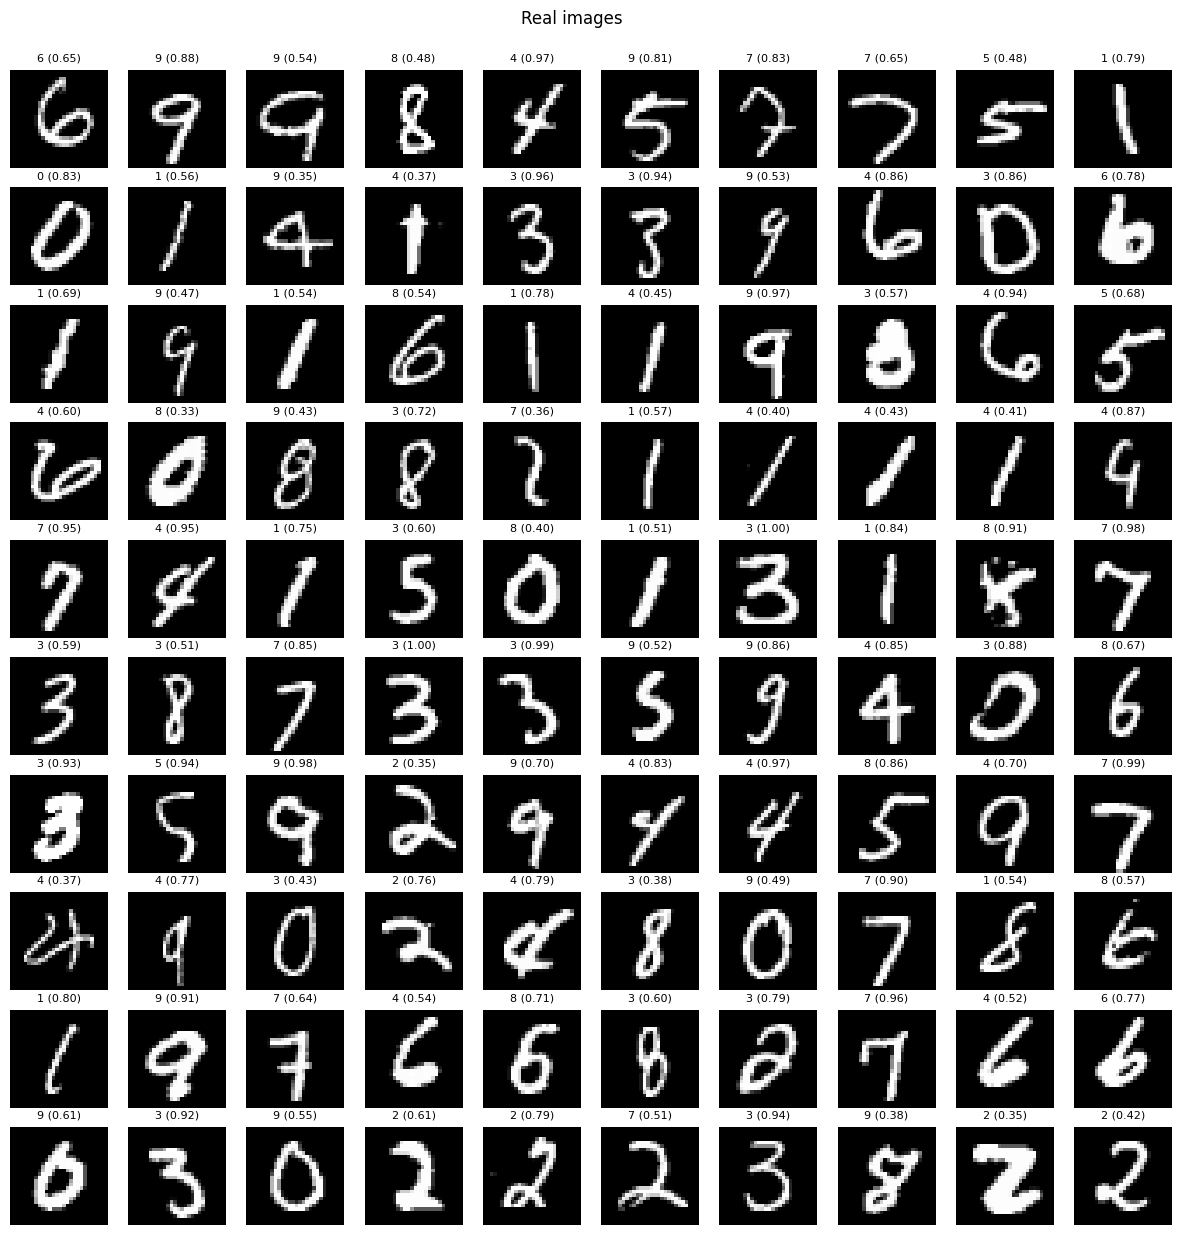

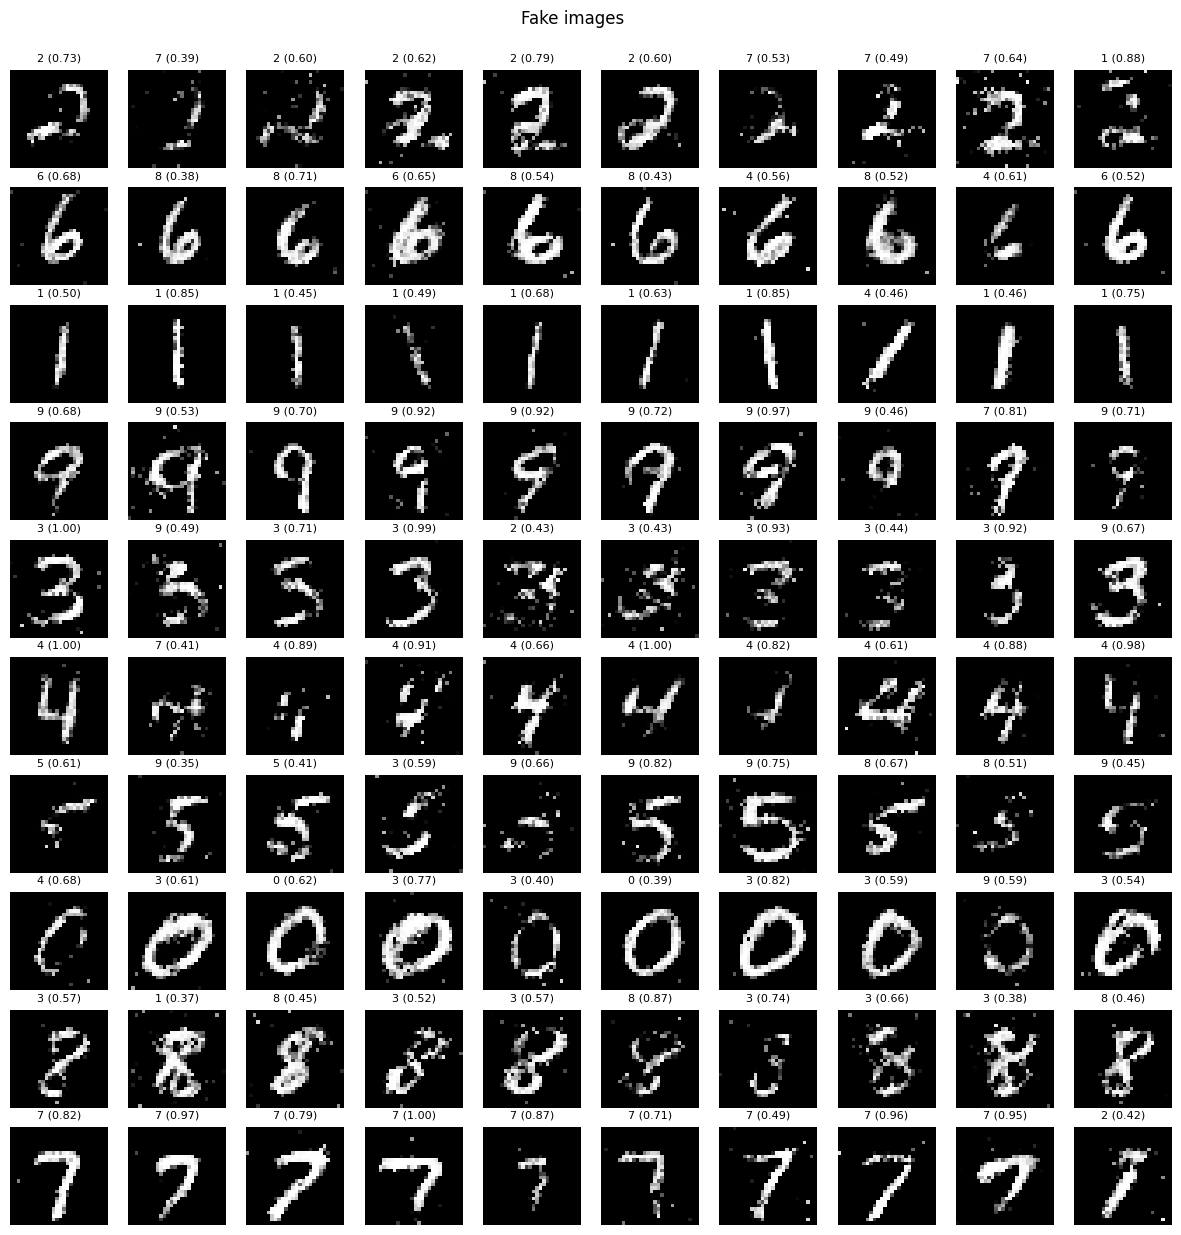

In [9]:
net.eval()
# 1) Gather all fake images into one big batch
all_fake = []
for gan in gans:
    gan.eval()
    with torch.no_grad():
        z = torch.randn(10, 100, device=device)
        fake = gan(z)                  # shape = (3, C, H, W)
        all_fake.append(fake)
fake_images = torch.cat(all_fake, dim=0)  # shape = (30, C, H, W)

# (Optional) If your GAN outputs in [-1,1] or uses a different normalization,
# undo it here before any plotting:
# fake_images = fake_images * 0.5 + 0.5   # if your GAN was trained with Normalize((0.5,), (0.5,))


for inputs, labels in trainloader_reduzido:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        # ---- Plot real images ----
        real_vis = inputs.cpu() * 0.5 + 0.5    # undo Normalize((0.5,), (0.5,))
        real_np = real_vis.numpy().squeeze()
        real_probs, real_preds = torch.softmax(outputs, dim=1).max(1)

        plt.figure(figsize=(15, 15))
        plt.suptitle("Real images", y=0.92)
        for i in range(100):
            plt.subplot(10, 10, i+1)
            plt.imshow(real_np[i], cmap='gray')
            plt.title(f"{real_preds[i].item()} ({real_probs[i].item():.2f})", fontsize=8)
            plt.axis('off')
        plt.show()

        # ---- Plot fake images ----
        # Make sure fake_images is on CPU and in [0,1]
        vis_fake = fake_images.cpu().clamp(0, 1).detach().numpy().squeeze()

        fake_outputs = net(fake_images.to(device))
        fake_probs, fake_preds = torch.softmax(fake_outputs, dim=1).max(1)

        plt.figure(figsize=(15, 15))
        plt.suptitle("Fake images", y=0.92)
        for i in range(100):
            plt.subplot(10, 10, i+1)
            # —— FIXED INDEXING —— use vis_fake[i], not vis_fake[0][i]
            plt.imshow(vis_fake[i], cmap='gray')
            plt.title(f"{fake_preds[i].item()} ({fake_probs[i].item():.2f})", fontsize=8)
            plt.axis('off')
        plt.show()

In [1]:
import re

def formatar_log(input_path: str, output_path: str) -> None:
    # Regex que captura: grupo1 = texto antes da perda, grupo2 = valor da perda,
    # grupo3 = texto antes da acurácia, grupo4 = valor da acurácia
    pattern = re.compile(r'(Rodada\s+\d+,\s+Perda:\s*)([\d\.]+)(,\s+Acuracia:\s*)([\d\.]+)')
    
    with open(input_path, 'r', encoding='utf-8') as fin, \
         open(output_path, 'w', encoding='utf-8') as fout:
        
        for line in fin:
            # Substitui cada ocorrência formatando os valores
            nova = pattern.sub(
                lambda m: f"{m.group(1)}{float(m.group(2)):.2f}"
                          f"{m.group(3)}{float(m.group(4)):.2f}",
                line
            )
            fout.write(nova)

In [2]:
formatar_log('file.txt', 'log_formatado.txt')
print("Formatação concluída! Arquivo salvo em 'log_formatado.txt'")

Formatação concluída! Arquivo salvo em 'log_formatado.txt'
